In [4]:
import sys # 파이썬 인터프리터가 제공하는 변수와 함수를 직접 제어할 수 있게 해주는 모듈

import torch
import torch.nn as nn # weight값이 있는 것들
import torch.nn.functional as F  # weight값이 없는 것들, pooling, activation
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import numpy as np

print(f"Python: {sys.version}")
print(f"Pytorch: {torch.__version__}")

Python: 3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]
Pytorch: 1.11.0+cu113


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


# Define Dataset

In [6]:
train_dataset = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = True,
    download = True,
    transform = transforms.Compose([transforms.ToTensor()]) # 데이터를 0에서 255까지 있는 값을 0에서 1사이 값으로 변환
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



In [7]:
test_dataset = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = False,
    download = True,
    transform = transforms.Compose([transforms.ToTensor()])
)

In [8]:
print(len(train_dataset))
print(len(test_dataset))

60000
10000


# Define DataLoader

In [9]:
batch_size = 32

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [11]:
# 데이터 확인
images, labels = next(iter(train_loader))

In [12]:
print("=====image informations=====")
print(images.shape)
print(type(images))
print(images.dtype)

print("\n=====labels informations=====")
print(labels.shape)
print(type(labels))
print(labels.dtype)

=====image informations=====
torch.Size([32, 1, 28, 28])
<class 'torch.Tensor'>
torch.float32

=====labels informations=====
torch.Size([32])
<class 'torch.Tensor'>
torch.int64


In [38]:
print(len(images))

32


# 데이터 시각화

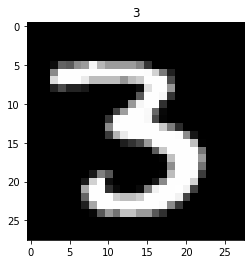

In [13]:
import random
idx = random.randint(0, 32)

torch_image = torch.squeeze(images[idx]) # [1, 28, 28] -> [28, 28]
np_image = torch_image.numpy()

label = labels[idx].numpy()

plt.title(label)
plt.imshow(np_image, 'gray')
plt.show()

# Define Model
- nn.Conv2d(in_channels = 1, out_channels = 20, kernel_size = 5, stride = 1)

In [25]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1) # ((W-K+2P)/S)+1 공식으로 인해 ((28-5+0)/1)+1=24 -> 24x24로 변환 -> maxpooling하면 12x12
    self.conv2 = nn.Conv2d(20, 50, 5, 1) # ((12-5+0)/1)+1=8 -> 8x8로 변환
    self.fc1 = nn.Linear(4*4*50, 100) # 4x4x50 vector로 flat한 것을 100개의 출력으로 변경
    self.fc2 = nn.Linear(100, 10) # 100개의 출력을 10개의 출력으로 변경
    self.maxpool = nn.MaxPool2d(2)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.maxpool(x)
    x = F.relu(self.conv2(x))
    x = self.maxpool(x)

    # print(x.shape)

    x = x.view(x.size(0), -1) # (batch_size, flatten_size)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return F.log_softmax(x, dim=1)

In [26]:
model = Net().to(device)
model

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

# Optimization

### 하이퍼파라미터(Hyperparameter)
- 에폭(epoch): 데이터셋을 반복하는 횟수
- 배치크기(batch size): 매개변수가 갱신되기 전 신경망을 통해 전파된 데이터 샘플의 수
- 학습률(learning rate)

In [27]:
# 하이퍼파라미터
learning_rate = 1e-3
epochs = 5

### 최적화 단계(Optimization Loop)
- 학습 단계(train loop): 학습용 데이터셋을 반복(iterate)하고 최적의 매개변수로 수렴
- 검증/테스트 단계(validatation/test loop): 모델 성능이 개선되고 있는지를 확인하기 위해 테스트 데이터셋을 반복

In [35]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)

  for batch, (X, y) in enumerate(dataloader):
    X = X.to(device)
    y = y.to(device)

    # 예측
    pred = model(X)
    # 손실
    loss = loss_fn(pred, y)

    print(loss)
    print(type(loss))

    # 역전파
    optimizer.zero_grad() # gradient를 0으로 초기화
    loss.backward() # 예측 손실을 역전파
    optimizer.step() # 역전파 단계에서 수집된 변화도로 매개변수 조정

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X) # dataset = 60000개, batch_size=32 -> 총 1875개의 batch가 존재
      print(f"loss: {loss:>7f}    [{current:>5d}/{size:>5d}]")

In [50]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X) # [bath_size, class_nums]
            print((pred.argmax(1)==y).type(torch.float).sum())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches # 평균값
    correct /= size # 맞게 예측한 개수 / 전체 개수
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

- pred = model(X): # [batch_size, class_nums] 각 class별 확률값
- pred.argmax(1): # [batch_size] 각 batch별 확률이 가장 높은 값의 인덱스 ex)[1, 0, 9, 8, 2, 3, 1, ...]
- pred.argmax(1)==y # [batch_size] batch별 예측 정확도 ex) [True, Fasle, True, True, False, ....]
- (pred.argmax(1)==y).type(torch.float).sum(): # [] 맞게 예측한 개수 ex) tensor(31.)

### train

In [30]:
# 손실함수
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [31]:
for i in range(epochs):
  print(f"Epoch {i+1}\n------------------------------")
  train_loop(train_loader, model, loss_fn, optimizer)
  test_loop(test_loader, model, loss_fn)
print("Done!")

Epoch 1
------------------------------
loss: 2.301781    [    0/60000]
loss: 2.291520    [ 3200/60000]
loss: 2.314212    [ 6400/60000]
loss: 2.302342    [ 9600/60000]
loss: 2.294911    [12800/60000]
loss: 2.295536    [16000/60000]
loss: 2.294560    [19200/60000]
loss: 2.292005    [22400/60000]
loss: 2.281476    [25600/60000]
loss: 2.291038    [28800/60000]
loss: 2.283676    [32000/60000]
loss: 2.295781    [35200/60000]
loss: 2.281287    [38400/60000]
loss: 2.276472    [41600/60000]
loss: 2.282428    [44800/60000]
loss: 2.263004    [48000/60000]
loss: 2.268022    [51200/60000]
loss: 2.255412    [54400/60000]
loss: 2.254984    [57600/60000]
Test Error: 
 Accuracy: 49.5%, Avg loss: 2.251436 

Epoch 2
------------------------------
loss: 2.247500    [    0/60000]
loss: 2.244694    [ 3200/60000]
loss: 2.238526    [ 6400/60000]
loss: 2.223430    [ 9600/60000]
loss: 2.238543    [12800/60000]
loss: 2.242568    [16000/60000]
loss: 2.194474    [19200/60000]
loss: 2.193383    [22400/60000]
loss: 

# 모델 저장하고 불러오기

### 모델 가중치 저장하고 불러오기
pytorch 모델은 학습한 매개변수를 state_dict라고 불리는 내부 상태 사전에 저장

In [ ]:
# 저장
# torch.save(model.state_dict(), 'model_weights.pth')

# 불러오기
# 먼저 동일한 모델의 인스턴스를 생성한 다음 load_state_dict() 메소드 사용
# model = Net()
# model.load_state_dict(torch.load('model_weights.pth'))
# model.eval() # 추론(inference)을 하기 전에 model.eval() 메소드를 호출하여 드롭아웃(dropout)과 배치 정규화(batch normalization)를 평가 모드(evaluation mode)로 설정해야 합니다.

### 모델의 형태를 포함하여 저장하고 불러오기
모델의 가중치를 불러올 때, 신경망의 구조를 정의하기 위해 모델 클래스를 먼저 생성(instantiate)해야 했습니다. 이 클래스의 구조를 모델과 함께 저장하고 싶으면, (model.state_dict()가 아닌) model 을 저장 함수에 전달합니다:

In [ ]:
# 저장
# torch.save(model, 'model.pth')

# 불러오기
# model = torch.load('model.pth')

### 체크포인트 저장하고 불러오기
추론(inference) 또는 학습(training)의 재개를 위해 체크포인트(checkpoint) 모델을 저장하고 불러오는 것은 마지막으로 중단했던 부분을 선택하는데 도움을 줄 수 있습니다. 체크포인트를 저장할 때는 단순히 모델의 state_dict 이상의 것을 저장해야 합니다. 모델 학습 중에 갱신되는 퍼버와 매개변수들을 포함하는 옵티마이저(Optimizer)의 state_dict를 함께 저장하는 것이 중요합니다. 이 외에도 중단 시점의 에포크(epoch), 마지막으로 기록된 학습 오차(training loss), 외부 torch.nn.Embedding 계층 등, 알고리즘에 따라 저장하고 싶은 항목들이 있을 것입니다.

In [ ]:
# 체크포인트 저장
# # 추가 정보
# EPOCH = 5
# PATH = "model.pt"
# LOSS = 0.4

# torch.save({
#             'epoch': EPOCH,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': LOSS,
#             }, PATH)

In [ ]:
# 체크포인트 불러오기
# 먼저 모델과 옵티마이저를 초기화한 뒤, 불러올 것!
# model = Net()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.eval() # 추론을 원하는 경우
# # - 또는 -
# model.train() # 학습을 계속하길 원하는 경우
